# Feature engineering and first models for Diabetes dataset

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv("data/diabetes_012_health_indicators_BRFSS2015.csv")

In [44]:
data["Diabetes_012"] = data["Diabetes_012"].astype(int)
data["HighBP"] = data["HighBP"].astype(int)
data["HighChol"] = data["HighChol"].astype(int)
data["CholCheck"] = data["CholCheck"].astype(int)
data["BMI"] = data["BMI"].astype(int)
data["Smoker"] = data["Smoker"].astype(int)
data["Stroke"] = data["Stroke"].astype(int)
data["HeartDiseaseorAttack"] = data["HeartDiseaseorAttack"].astype(int)
data["PhysActivity"] = data["PhysActivity"].astype(int)
data["Fruits"] = data["Fruits"].astype(int) 
data["Veggies"] = data["Veggies"].astype(int)
data["HvyAlcoholConsump"] = data["HvyAlcoholConsump"].astype(int)
data["AnyHealthcare"] = data["AnyHealthcare"].astype(int)
data["NoDocbcCost"] = data["NoDocbcCost"].astype(int)
data["GenHlth"] = data["GenHlth"].astype(int)
data["MentHlth"] = data["MentHlth"].astype(int)
data["PhysHlth"] = data["PhysHlth"].astype(int)
data["DiffWalk"] = data["DiffWalk"].astype(int)
data["Sex"] = data["Sex"].astype(int)
data["Age"] = data["Age"].astype(int)
data["Education"] = data["Education"].astype(int)
data["Income"] =data["Income"].astype(int)

### Remove outliers from BMI

In [4]:
df_filtered = data.copy(deep=True)

# Identify outliers for BMI
Q1 = df_filtered['BMI'].quantile(0.25)
Q3 = df_filtered['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers for BMI
outliers_bmi = (df_filtered['BMI'] < lower_bound) | (df_filtered['BMI'] > upper_bound)

# Replace outliers with the last valid value
last_valid_bmi = df_filtered['BMI'][~outliers_bmi].iloc[-1]
df_filtered.loc[outliers_bmi, 'BMI'] = last_valid_bmi

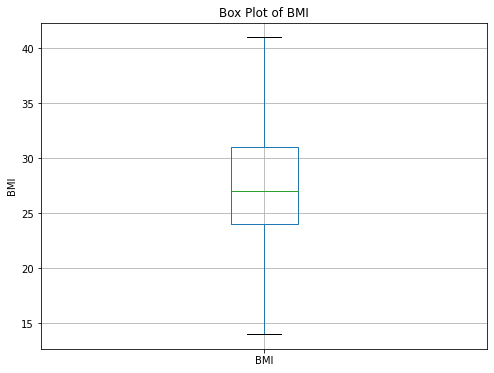

In [47]:
plt.figure(figsize=(8, 6))
df_filtered.boxplot(column=['BMI'])
plt.title('Box Plot of BMI')
plt.ylabel('BMI')
plt.show()

### Binning of PhysHlth and MentHlth

In [5]:
df_filtered["PhysHlth"] = pd.cut(df_filtered["PhysHlth"],
bins=[-np.inf, 5., 10., 15., 20., 25., np.inf],
labels=[1, 2, 3, 4, 5, 6])

In [6]:
df_filtered["PhysHlth"].value_counts()

1    206863
6     20305
2     12451
3      8209
4      3655
5      2197
Name: PhysHlth, dtype: int64

In [7]:
df_filtered["MentHlth"] = pd.cut(df_filtered["MentHlth"],
bins=[-np.inf, 5., 10., 15., 20., 25., np.inf],
labels=[1, 2, 3, 4, 5, 6])

In [74]:
df_filtered["MentHlth"].value_counts()

1    217472
6     12697
2     11191
3      7152
4      3619
5      1549
Name: MentHlth, dtype: int64

### Remove prediabetes from dataset

In [8]:
df_filtered_binary = df_filtered[(df_filtered["Diabetes_012"] == 0) | (df_filtered["Diabetes_012"] == 2)]

In [9]:
train_set, v_t_set = train_test_split(
df_filtered_binary, test_size=0.3, stratify=df_filtered_binary["Diabetes_012"], random_state=42)

validation_set, test_set = train_test_split(
v_t_set, test_size=0.3, stratify=v_t_set["Diabetes_012"], random_state=42)

#validation_set.to_csv("data/validation_set.csv", index=False)
#test_set.to_csv("data/test_set.csv", index = False)
#train_set.to_csv("data/train_set.csv", index = False)

In [10]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
train_binary_scaled = pd.DataFrame(min_max_scaler.fit_transform(train_set.values), columns=train_set.columns, index=train_set.index)

In [12]:
test_binary_scaled = pd.DataFrame(min_max_scaler.transform(test_set.values), columns=test_set.columns, index=test_set.index)

In [13]:
train_binary_scaled.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
40181,0.0,1.0,0.0,1.0,0.407407,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.833333,1.0,1.000000
147865,0.0,0.0,0.0,0.0,0.703704,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.50,0.4,0.0,0.0,1.0,0.500000,0.6,1.000000
32456,0.0,1.0,0.0,1.0,0.703704,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.75,0.0,0.0,0.0,0.0,0.583333,0.6,0.285714
165934,1.0,1.0,1.0,1.0,0.444444,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.0,0.0,1.0,1.0,0.916667,1.0,0.285714
253446,0.0,1.0,1.0,1.0,0.777778,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.75,0.4,0.2,1.0,0.0,0.833333,0.2,0.000000


In [14]:
X_train = train_binary_scaled.loc[:, train_binary_scaled.columns != 'Diabetes_012']
y_train = train_binary_scaled["Diabetes_012"]

X_test = test_binary_scaled.loc[:, test_binary_scaled.columns != 'Diabetes_012']
y_test = test_binary_scaled["Diabetes_012"]

In [ ]:
# Define hyperparameters for Logistic Regression
logistic_regression_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    'solver': ['lbfgs', 'saga'],  # Solver for optimization problem
    'penalty': ['l1', 'l2']  # Regularization penalty
}

# Define hyperparameters for k-Nearest Neighbors
knn_params = {
    'n_neighbors': list(range(1, 31)),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Define hyperparameters for Random Forest
random_forest_params = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Perform grid search for Logistic Regression
grid_search_logistic = GridSearchCV(LogisticRegression(), logistic_regression_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_logistic.fit(X_train, y_train)

# Perform grid search for k-Nearest Neighbors
grid_search_knn = GridSearchCV(KNeighborsClassifier(), knn_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Perform grid search for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), random_forest_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Print best parameters and corresponding scores for each classifier
print("Best parameters for Logistic Regression:")
print(grid_search_logistic.best_params_)
print("Best cross-validation accuracy score for Logistic Regression: {:.2f}".format(grid_search_logistic.best_score_))

print("Best parameters for k-Nearest Neighbors:")
print(grid_search_knn.best_params_)
print("Best cross-validation accuracy score for k-Nearest Neighbors: {:.2f}".format(grid_search_knn.best_score_))

print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)
print("Best cross-validation accuracy score for Random Forest: {:.2f}".format(grid_search_rf.best_score_))



Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/hubert/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hubert/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hubert/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/hubert/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", 

Fitting 5 folds for each of 120 candidates, totalling 600 fits
